In [1]:
import os
import pandas as pd
import numpy as np

# import required libaries to process images
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 
 
#using Keras

In [6]:
#get list of images 
dir = os.getcwd()
image_file = os.listdir('{}/assets/wildfire_test_set'.format(dir))
image_file = [file for file in images if '.DS_Store' not in file]
image_arrays = [np.asarray(Image.open('{}/assets/wildfire_test_set/{}'.format(dir,image))) for image in image_file] 

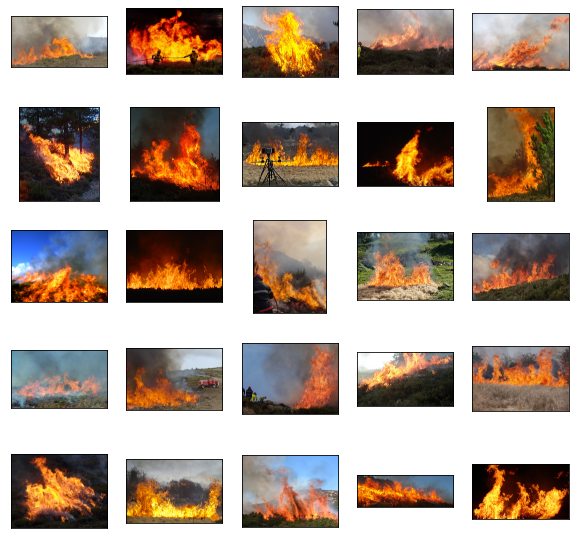

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_arrays[i])